Matplotlib created a temporary config/cache directory at /var/folders/7m/mqkfpjl97fv2sybjq8l1qv3r0000gn/T/matplotlib-tc1d_aaf because the default path (/Users/jan/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/var/folders/7m/mqkfpjl97fv2sybjq8l1qv3r0000gn/T/ipykernel_6738/1346666107.py:31: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  z_T = np.fromstring(x[0:n],dtype='u1')-ord('0')
/var/folders/7m/mqkfpjl97fv2sybjq8l1qv3r0000gn/T/ipykernel_6738/1346666107.py:35: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  y = np.fromstring(x[n:2*n],dtype='u1')-ord('0')


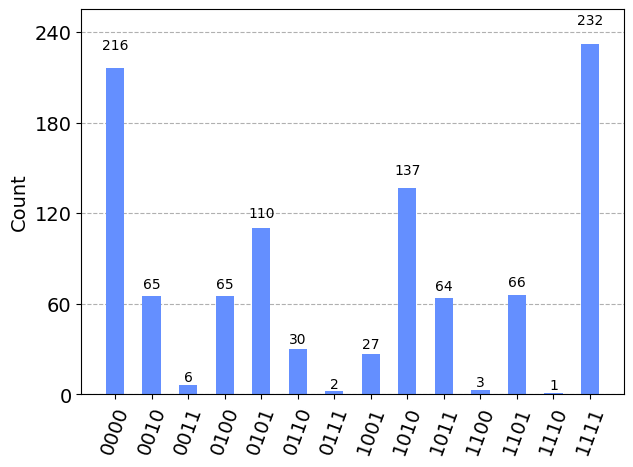

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram

#instance for problem
#given Inverse matrix
A_m1 = np.array([[1,1],[0,1]])
n = np.sqrt(A_m1.size).astype(int)
nqubits = 2*n

#initialize functions
def vMv_product(x,A):
    """
    Given a 2n bit string x and an nxn Matrix A, the function returns the 
    required Vector-Matrix-Vector product
    
    Args:
        x:str
        solution bitstring
        
        A:Problem Matrix
    
    Returns:
        obj: float
    """
    n = np.sqrt(A.size).astype(int)
    z_T = np.fromstring(x[0:n],dtype='u1')-ord('0')
    z_T = -1*z_T
    z_T[z_T==0]=1
    z_T.reshape(1,n)
    y = np.fromstring(x[n:2*n],dtype='u1')-ord('0')
    y = -1*y
    y[y==0]=1
    obj = -z_T.dot(A.dot(y)).astype(int) #include minus because optimizer we use minimizes obj
    
    return obj

def compute_expectation(counts, A):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        A: Problem Matrix
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = vMv_product(bitstring[::-1], A)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def create_qaoa_circ(A, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        A: problem Matrix
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    n = np.sqrt(A.size).astype(int)
    nqubits = 2*n
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for i in range(n):
            for j in range(n):
                qc.rzz(2*A[i,j].astype(int)* gamma[irep], i, j+n)
                qc.barrier()
                #w.append(A_m1[i,j].astype(int))
        
        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

def get_expectation(A, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(A, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512*3).result().get_counts()
        
        return compute_expectation(counts, A)
    
    return execute_circ

expectation = get_expectation(A_m1)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')

backend = Aer.get_backend('aer_simulator')
backend.shots = 512*3

qc_res = create_qaoa_circ(A_m1, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

#print(counts)

#print(vMv_product('101111',A_m1))

In [42]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt
import numpy as np

#instance for problem
#given Inverse matrix
A_m1 = np.array([[1,-1],[0,1]])
n = np.sqrt(A_m1.size).astype(int)
nqubits = 2*n

#implement mixing hamiltonian
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

#implement Problem hamiltonian
#define weights
w = [A_m1[0,0].astype(int), A_m1[0,1].astype(int), A_m1[1,0].astype(int), A_m1[1,1].astype(int)]

gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
#for pair in list(G.edges()):  # pairs of nodes
#    qc_p.rzz(2 * gamma, pair[0], pair[1])
#    qc_p.barrier()
#introduce hamiltonian based on weights
qc_p.rzz(2 * gamma, 0, 2)
qc_p.barrier()
qc_p.rzz(-2 * gamma, 0, 3)
qc_p.barrier()
#pair 1,2 is missing because of matrix
qc_p.rzz(2 * gamma, 1, 3)
qc_p.barrier()
    
qc_p.decompose().draw()

#initial state in superposition
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

#start with QAOA implementation
qc_qaoa = QuantumCircuit(nqubits)

#adding all aprts together
qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.measure_all()

qc_qaoa.decompose().decompose().draw()


┌─────────┐                             ░                              »
   q_0: ┤ U2(0,π) ├──■──────────────────────■───░───■───────────────────────■──»
        ├─────────┤  │                      │   ░   │                       │  »
   q_1: ┤ U2(0,π) ├──┼──────────────────────┼───░───┼───────────────────────┼──»
        ├─────────┤┌─┴─┐┌────────────────┐┌─┴─┐ ░   │                       │  »
   q_2: ┤ U2(0,π) ├┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼───────────────────────┼──»
        ├─────────┤└───┘└────────────────┘└───┘ ░ ┌─┴─┐┌─────────────────┐┌─┴─┐»
   q_3: ┤ U2(0,π) ├─────────────────────────────░─┤ X ├┤ Rz(-2*$\gamma$) ├┤ X ├»
        └─────────┘                             ░ └───┘└─────────────────┘└───┘»
meas_0: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
meas_1: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
meas_2: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
meas_3: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
«         ░                              ░ ┌────────────────┐ ░ ┌─┐         
«   q_0: ─░──────────────────────────────░─┤ R(2*$\beta$,0) ├─░─┤M├─────────
«         ░                              ░ ├────────────────┤ ░ └╥┘┌─┐      
«   q_1: ─░───■──────────────────────■───░─┤ R(2*$\beta$,0) ├─░──╫─┤M├──────
«         ░   │                      │   ░ ├────────────────┤ ░  ║ └╥┘┌─┐   
«   q_2: ─░───┼──────────────────────┼───░─┤ R(2*$\beta$,0) ├─░──╫──╫─┤M├───
«         ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ ├────────────────┤ ░  ║  ║ └╥┘┌─┐
«   q_3: ─░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─┤ R(2*$\beta$,0) ├─░──╫──╫──╫─┤M├
«         ░ └───┘└────────────────┘└───┘ ░ └────────────────┘ ░  ║  ║  ║ └╥┘
«meas_0: ════════════════════════════════════════════════════════╩══╬══╬══╬═
«                                                                   ║  ║  ║ 
«meas_1: ═══════════════════════════════════════════════════════════╩══╬══╬═
«                                                                      ║  ║ 
«meas_2: ══════════════════════════════════════════════════════════════╩══╬═
«                                                                         ║ 
«meas_3: ═════════════════════════════════════════════════════════════════╩═
«

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt
import numpy as np

####
#instance for problem
#given Inverse matrix
A_m1 = np.array([[1,-1],[0,1]])
n = np.sqrt(A_m1.size).astype(int)
nqubits = 2*n

#implement mixing hamiltonian
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

#implement Problem hamiltonian
#define weights
w = []

gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
#for pair in list(G.edges()):  # pairs of nodes
#    qc_p.rzz(2 * gamma, pair[0], pair[1])
#    qc_p.barrier()
#introduce hamiltonian based on weights
for i in range(n):
    for j in range(n):
        qc_p.rzz(2*A_m1[i,j].astype(int)* gamma, i, j+n)
        qc_p.barrier()
        w.append(A_m1[i,j].astype(int))
#qc_p.rzz(-2 * gamma, 0, 3)
#qc_p.barrier()
#pair 1,2 is missing because of matrix
#qc_p.rzz(2 * gamma, 1, 3)
#qc_p.barrier()
    
qc_p.decompose().draw()

#initial state in superposition
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

#start with QAOA implementation
qc_qaoa = QuantumCircuit(nqubits)

#adding all aprts together
qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.measure_all()

qc_qaoa.decompose().decompose().draw()

Matplotlib created a temporary config/cache directory at /var/folders/7m/mqkfpjl97fv2sybjq8l1qv3r0000gn/T/matplotlib-htg5o3fb because the default path (/Users/jan/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


┌─────────┐                             ░                              »
   q_0: ┤ U2(0,π) ├──■──────────────────────■───░───■───────────────────────■──»
        ├─────────┤  │                      │   ░   │                       │  »
   q_1: ┤ U2(0,π) ├──┼──────────────────────┼───░───┼───────────────────────┼──»
        ├─────────┤┌─┴─┐┌────────────────┐┌─┴─┐ ░   │                       │  »
   q_2: ┤ U2(0,π) ├┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼───────────────────────┼──»
        ├─────────┤└───┘└────────────────┘└───┘ ░ ┌─┴─┐┌─────────────────┐┌─┴─┐»
   q_3: ┤ U2(0,π) ├─────────────────────────────░─┤ X ├┤ Rz(-2*$\gamma$) ├┤ X ├»
        └─────────┘                             ░ └───┘└─────────────────┘└───┘»
meas_0: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
meas_1: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
meas_2: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
meas_3: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
«         ░                     ░                              ░ »
«   q_0: ─░─────────────────────░──────────────────────────────░─»
«         ░                     ░                              ░ »
«   q_1: ─░───■─────────────■───░───■──────────────────────■───░─»
«         ░ ┌─┴─┐┌───────┐┌─┴─┐ ░   │                      │   ░ »
«   q_2: ─░─┤ X ├┤ Rz(0) ├┤ X ├─░───┼──────────────────────┼───░─»
«         ░ └───┘└───────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ »
«   q_3: ─░─────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─»
«         ░                     ░ └───┘└────────────────┘└───┘ ░ »
«meas_0: ════════════════════════════════════════════════════════»
«                                                                »
«meas_1: ════════════════════════════════════════════════════════»
«                                                                »
«meas_2: ════════════════════════════════════════════════════════»
«                                                                »
«meas_3: ════════════════════════════════════════════════════════»
«                                                                »
«        ┌────────────────┐ ░ ┌─┐         
«   q_0: ┤ R(2*$\beta$,0) ├─░─┤M├─────────
«        ├────────────────┤ ░ └╥┘┌─┐      
«   q_1: ┤ R(2*$\beta$,0) ├─░──╫─┤M├──────
«        ├────────────────┤ ░  ║ └╥┘┌─┐   
«   q_2: ┤ R(2*$\beta$,0) ├─░──╫──╫─┤M├───
«        ├────────────────┤ ░  ║  ║ └╥┘┌─┐
«   q_3: ┤ R(2*$\beta$,0) ├─░──╫──╫──╫─┤M├
«        └────────────────┘ ░  ║  ║  ║ └╥┘
«meas_0: ══════════════════════╩══╬══╬══╬═
«                                 ║  ║  ║ 
«meas_1: ═════════════════════════╩══╬══╬═
«                                    ║  ║ 
«meas_2: ════════════════════════════╩══╬═
«                                       ║ 
«meas_3: ═══════════════════════════════╩═
«

/var/folders/7m/mqkfpjl97fv2sybjq8l1qv3r0000gn/T/ipykernel_40968/636901341.py:31: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  z_T = np.fromstring(x,dtype='u1')-ord('0')


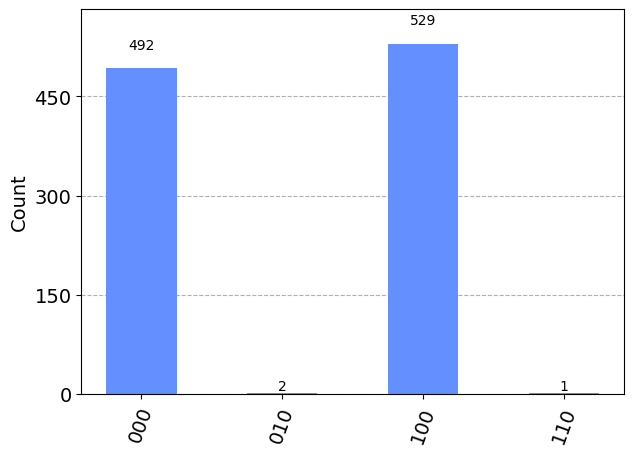

In [6]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram

#instance for problem
#given vector
A_m1 = np.array([1,1,0])
n = A_m1
nqubits = n

#initialize functions
def vM_product(x,v):
    """
    Given a 2n bit string x and an nxn Matrix A, the function returns the 
    required Vector-Matrix-Vector product
    
    Args:
        x:str
        solution bitstring
        
        v:Problem Vector
    
    Returns:
        obj: float
    """
    n = v.size
    z_T = np.fromstring(x,dtype='u1')-ord('0') #import string in correct datatype
    z_T = -1*z_T #inverse canonical trafo
    z_T[z_T==0]=1
    z_T.reshape(1,n)
    obj = -z_T.dot(v).astype(int) #include minus because optimizer we use minimizes obj
    
    return obj

def compute_expectation(counts, A):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        A: Problem Matrix
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = vM_product(bitstring[::-1], A)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def create_qaoa_circ(v, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        v: problem Vector
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    n = v.size
    nqubits = n
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for i in range(n):
            qc.rz(2*v[i].astype(int)* gamma[irep], i)
            qc.barrier()
        
        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

def get_expectation(A, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(A, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, A)
    
    return execute_circ

expectation = get_expectation(A_m1)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(A_m1, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

#print(counts)

#print(vM_product('110',A_m1))